In [5]:
import simdata
import matplotlib.pyplot as plt
import casatasks

In [9]:
%load_ext autoreload

In [3]:
msname='dsa110-calsrc.ms'
imagebase = 'first'
caldirection="J2000 12h00m00.0s 50d00m00.0s"
srcdirection=None

In [3]:
simdata.simulate(msname=msname, imagename='first_12h+50d.ms', calobsdir=caldirection, srcobsdir=srcdirection, freq='1.4GHz', integrationtime='1s', diameter=5.0, noise='0Jy', gainnoise=0)

In [4]:
data = simdata.read(msname=msname)

2019-09-09 11:24:36,279 - simdata - INFO - Read data of shape: (2, 1, 105, 900)


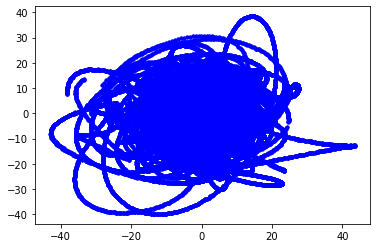

In [5]:
plt.plot(data.flatten().real, data.flatten().imag, 'b.') 

In [6]:
data

array([[[[-13.90465832 -6.87160969j, -13.79448414 -6.88273573j,
          -13.79450607 -6.88268995j, ..., -22.13140106 -4.0629425j ,
          -22.13141441 -4.0628686j , -21.7508316  -4.32003117j],
         [  7.37574244 +1.1415838j ,   7.53217173 +1.10629857j,
            7.81743336 +0.91123116j, ...,  -3.90478373 +4.54842091j,
           -3.90132594 +4.47914743j,  -3.89470768 +4.52979755j],
         [  6.67929745 +4.15561152j,   6.47183752 +4.57570696j,
            6.34379673 +4.95115089j, ...,  11.16087437 +3.72900057j,
           11.08657265 +3.84943295j,  10.93544483 +4.08812141j],
         ...,
         [  7.96831942 -9.17294312j,   7.85040951 -9.27235985j,
            7.7300806  -9.36825943j, ...,  -0.81219679 +6.21276331j,
           -0.89197582 +6.25516224j,  -0.93316966 +6.27805376j],
         [  3.32982731 +5.74395847j,   3.45574427 +5.68595123j,
            3.70126891 +5.56866312j, ...,  -0.1614013 +13.62796593j,
           -0.0468679 +13.65939522j,   0.18939805+13.71076298

In [6]:
casatasks.tclean(vis=msname, imagename=imagebase, field='cal', spw='0', cell='2arcsec', imsize=2048, datacolumn='data')

{}

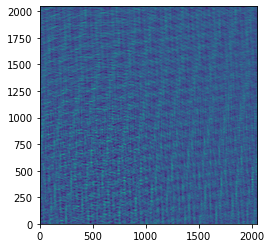

In [10]:
simdata.display(imname=imagebase + '.image')